## Define Model Architecture

In [141]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    """(convolution => [BN] => LeakyReLU) * 2"""
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.LeakyReLU(0.01, inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.01, inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    """Downscaling with maxpool then double conv"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    """Upscaling then double conv"""
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
        
        self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = torch.tensor([x2.size()[2] - x1.size()[2]])
        diffX = torch.tensor([x2.size()[3] - x1.size()[3]])

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 512)
        self.up1 = Up(1024, 256)
        self.up2 = Up(512, 128)
        self.up3 = Up(256, 64)
        self.up4 = Up(128, 64)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits


## Define Data Loader

In [142]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os

import random as rand
import torch
from torchvision.transforms import functional as F

class AddGaussianNoise(object):
    def __init__(self, random_interval):
        """
        Args:
            random_interval:        Interval to randomly sample
            tuple(float, float)     the standard deviation of the 
                                    Gaussian noise to add.
        """
        self.mean = 0
        self.std = round(rand.uniform(random_interval[0], random_interval[1]), 4)

    def __call__(self, img):
        """
        Args:
            img (PIL.Image or torch.Tensor): Image to be noised

        Returns:
            PIL.Image or torch.Tensor: Noised image
        """
        if isinstance(img, torch.Tensor):
            noise = torch.normal(self.mean, self.std, img.size())
            noisy_img_tensor = img + noise
            return torch.clamp(noisy_img_tensor, 0, 1)
            
        else:
            # Convert image to tensor, add noise, and convert back if the input is a PIL Image
            img_tensor = F.to_tensor(img)
            noise = torch.randn(img_tensor.size()) * self.std + self.mean
            noised_img = img_tensor + noise
            return F.to_pil_image(noised_img)

    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

def check_and_flip_image(image):
    width, height = image.size
    if height > width:
        image = image.transpose(Image.ROTATE_90)
    return image


class DenoisingDataset(Dataset):
    def __init__(self, root_dir, transform=None, train=True):
        """
        Args:
            - root_dir (string): Directory with all the images.
            - noise_level (int): Specific noise level of noisy images to use.
            - transform (callable, optional): Optional transform to be applied on a sample.
        """
        dataset_split = 0.9
        noise_levels = [5, 10, 15, 25, 35, 50]
        original_fnames = os.listdir(os.path.join(root_dir, "original_png"))

        dataset_fnames = (
            original_fnames[: int(len(original_fnames) * dataset_split)]
            if train
            else original_fnames[int(len(original_fnames) * dataset_split) :]
        )

        self.root_dir = root_dir
        self.transform = transform
        self.image_objects = [
            {"img_id": fname[:-4]}
            for fname in dataset_fnames
        ]

    def __len__(self):
        return len(self.image_objects)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_object = self.image_objects[idx]

        original_img_path = os.path.join(
            self.root_dir, "original_png", f"{img_object['img_id']}.png"
        )

        original_image = Image.open(original_img_path).convert("RGB")

        original_image = check_and_flip_image(original_image)

        if self.transform:
            original_image = self.transform(original_image)

        noise_transform = AddGaussianNoise((0.05, 0.5))
        noisy_image = noise_transform(original_image)

        return noisy_image, original_image

## Train Function

In [143]:
import time
import datetime
from IPython.display import display, clear_output


def train(model, dataloader, optimiser, criterion, epochs):
    losses_storage = []
    average_batch_time = 0

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model.train()
    model.to(device)

    print("Training started\n")

    for epoch in range(epochs):
        running_loss = 0.0

        for i, (noisy_images, original_images) in enumerate(dataloader):
            batch_time = time.time()
            noisy_images = noisy_images.to(device)
            original_images = original_images.to(device)

            optimiser.zero_grad()
            outputs = model(noisy_images)

            loss = criterion(outputs, original_images)
            loss.backward()

            optimiser.step()
            running_loss += loss.item()
            losses_storage.append(loss.item())

            # calculating the percentage done and ETA
            total_epochs = epochs
            total_batches = len(dataloader)
            current_batch_num = epoch * total_batches + i + 1

            percentage = (current_batch_num / (total_epochs * total_batches)) * 100

            average_batch_time = (
                average_batch_time * (current_batch_num - 1)
                + (time.time() - batch_time)
            ) / (current_batch_num)

            time_remaining = average_batch_time * (
                total_epochs * total_batches - current_batch_num
            )
            eta = datetime.datetime.now() + datetime.timedelta(seconds=round(time_remaining))

            clear_output(wait=False)

            print("Training started\n")
            print(
                f"Current State\n-------------\nEpoch: {epoch+1}/{total_epochs} \nBatch: {i+1}/{total_batches} \nCurrent Loss: {loss.item()} \nPercentage: {percentage:.2f}% \nETA: {eta.strftime('%H:%M:%S')}"
            )

    print("\n\nTraining finished")
    print(f"Final loss: {losses_storage[-1]}")

    return losses_storage

## Test Function

In [151]:
def test(model, dataloader, criterion):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for images, targets in dataloader:
            outputs = model(images)
            loss = criterion(outputs, targets)
            total_loss += loss.item()

    print(f"Test Loss: {total_loss/len(dataloader)}")

## Load Dataset

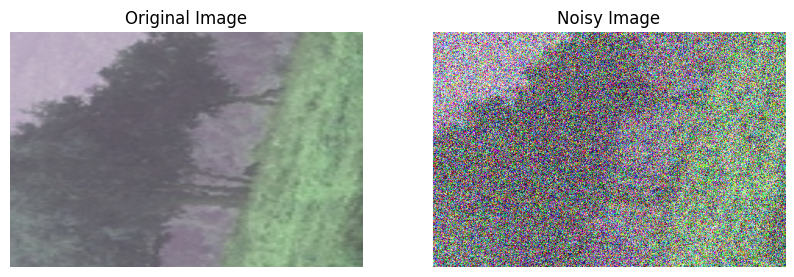

In [355]:
from torchvision import transforms

transform = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(0.5),
        transforms.RandomVerticalFlip(0.5),
        transforms.RandomOrder(
            [
                transforms.ColorJitter(brightness=(0.5, 1.5)),
                transforms.ColorJitter(contrast=(0.5, 1.5)),
                transforms.ColorJitter(saturation=(0.5, 1.5)),
                transforms.ColorJitter(hue=(-0.2, 0.2)),
            ]
        ),
        transforms.RandomChoice(
            [
                transforms.Compose(
                    [
                        transforms.RandomChoice(
                            [
                                transforms.RandomAffine((10, 80)),
                                transforms.RandomRotation((10, 80)),
                            ]
                        ),
                        transforms.RandomResizedCrop((320, 480), (0.1, 0.1)),
                    ]
                ),
                transforms.RandomResizedCrop((320, 480), (0.5, 1)),
            ]
        ),
        transforms.ToTensor(),
    ]
)

training_dataset = DenoisingDataset(root_dir="CBSD68", transform=transform, train=True)
test_dataset = DenoisingDataset(root_dir="CBSD68", transform=transform, train=False)

import matplotlib.pyplot as plt

# Assuming dataset is the instance of AdjustedDenoisingDataset
noisy_image, original_image = training_dataset[
    rand.randint(0, len(training_dataset) - 1)
]

# Convert the tensors to PIL images
noisy_image_pil = transforms.ToPILImage()(noisy_image)
original_image_pil = transforms.ToPILImage()(original_image)

# Display the images
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(original_image_pil)
axes[0].set_title("Original Image")
axes[0].axis("off")
axes[1].imshow(noisy_image_pil)
axes[1].set_title("Noisy Image")
axes[1].axis("off")

plt.show()

## Train Model

In [337]:
import torch.optim as optim

num_epochs = 20
batch_size = 32
lr = 0.0005

model = UNet(n_channels=3, n_classes=3)
dataloader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
optimiser = optim.AdamW(model.parameters(), lr=lr)
criterion = nn.MSELoss()

losses_storage = train(model, dataloader, optimiser, criterion, num_epochs)

Training started

Current State
-------------
Epoch: 20/20 
Batch: 2/2 
Current Loss: 0.024885032325983047 
Percentage: 100.00% 
ETA: 18:48:19


Training finished
Final loss: 0.024885032325983047


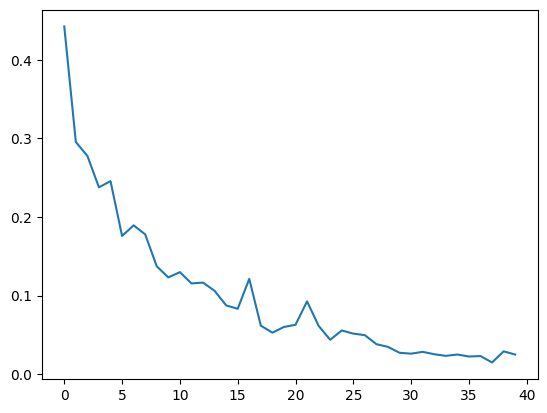

In [338]:
import matplotlib.pyplot as plt

plt.plot(losses_storage)

In [341]:
dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

criterion = nn.MSELoss()

test(model, dataloader, criterion)

Test Loss: 0.03347308561205864


## Save and Load Model

In [162]:
# Save model
import os

# Create the '2_saved_models' folder if it doesn't exist
save_folder = '2_saved_models'
os.makedirs(save_folder, exist_ok=True)

while True:
  filename = input("Enter filename to save model: \n")
  save_path = os.path.join(save_folder, f'{filename}.pth')
  
  try:
    torch.save(model.state_dict(), save_path)
    break
  except FileExistsError:
    print("File already exists. Please enter a different filename.")


In [ ]:
# Load model
import os

# List all the files in the '2_saved_models' folder
saved_models_folder = '2_saved_models'
model_files = os.listdir(saved_models_folder)

# Display the available model files
print("Available model files:")
for i, file in enumerate(model_files):
    print(f"{i+1}. {file}")

# Prompt the user to enter the index of the model file they want to load
selected_index = int(input("Enter the index of the model file to load: ")) - 1

# Load the selected model file
selected_model_file = model_files[selected_index]
model_path = os.path.join(saved_models_folder, selected_model_file)
model = UNet(n_channels=3, n_classes=3)
model.load_state_dict(torch.load(model_path))

## Test an Image

Loss value (MSE): 0.03165656328201294


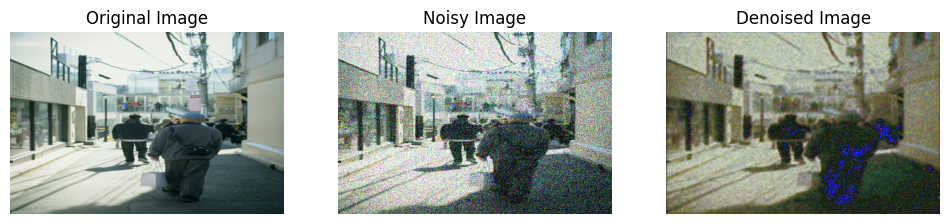

In [342]:
import requests
from PIL import Image
import numpy as np
import torch
import torch.nn.functional as F
from torchvision import transforms
from io import BytesIO
import matplotlib.pyplot as plt

# Additional function to convert tensor to PIL Image for visualization
def tensor_to_pil(tensor):
    unloader = transforms.ToPILImage()  # Convert tensor to PIL Image
    image = tensor.cpu().clone()  # Clone the tensor to not do changes on it
    image = image.squeeze(0)      # Remove the fake batch dimension
    image = unloader(image)
    return image

# Function to fetch image
def fetch_image(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    img = img.convert('RGB') 
    return img

# Function to denoise image using model
def denoise_image(image_tensor):
    model.eval()

    preprocess = transforms.Compose([
        transforms.Resize((320, 480)),
        transforms.ToTensor(),
        # Add any other preprocessing (e.g., normalization)
    ])

    input_tensor = image_tensor.unsqueeze(0)  # Add batch dimension
    with torch.no_grad():
        output = model(input_tensor)
    return output.squeeze(0)  # Remove batch dimension


def process_image(image_url, noise_level):
    original_image = fetch_image(image_url)
    # noisy_image = add_awgn_to_image(original_image, noise_level)
    # Convert original_image to tensor for loss computation
    preprocess = transforms.Compose([
        transforms.Resize((320, 480)),
        transforms.ToTensor(),
    ])
    original_image_tensor = preprocess(original_image)
    original_image = tensor_to_pil(original_image_tensor)
    noisy_image_tensor = AddGaussianNoise((noise_level, noise_level))(original_image_tensor)

    denoised_image_tensor = denoise_image(noisy_image_tensor)
    denoised_image = tensor_to_pil(denoised_image_tensor)
    noisy_image = tensor_to_pil(noisy_image_tensor)

    # Compute loss
    loss = F.mse_loss(denoised_image_tensor, original_image_tensor)
    print(f"Loss value (MSE): {loss.item()}")

    # Visualization
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(original_image)
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(noisy_image)
    plt.title("Noisy Image")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(denoised_image)
    plt.title("Denoised Image")
    plt.axis('off')

    plt.show()

image_url = input("Enter the URL of the image to denoise: \n")
noise_level = float(input("Enter the noise level (0-100): \n")) / 100
process_image(image_url, noise_level)
